# Anemia Detection System using Machine Learning

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    recall_score
)


# Loading the Dataset

In [2]:
# Loading anemia dataset
data = pd.read_csv("C:\\anemia.csv")


In [3]:
# Display basic information
# displaying the first 5 rows
data.head()

,Gender,Hemoglobin,MCH,MCHC,MCV,Result
0,1,14.9,22.7,29.1,83.7,0
1,0,15.9,25.4,28.3,72.0,0
2,0,9.0,21.5,29.6,71.2,1
3,0,14.9,16.0,31.4,87.5,0
4,1,14.7,22.0,28.2,99.5,0


In [4]:
# information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      1421 non-null   int64  
 1   Hemoglobin  1421 non-null   float64
 2   MCH         1421 non-null   float64
 3   MCHC        1421 non-null   float64
 4   MCV         1421 non-null   float64
 5   Result      1421 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 66.7 KB


In [5]:
# shape of the dataset
print("Dataset shape:", data.shape)


Dataset shape: (1421, 6)


# Data Cleaning

In [6]:
# Checking for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 Gender        0
Hemoglobin    0
MCH           0
MCHC          0
MCV           0
Result        0
dtype: int64


In [7]:
# Checking for duplicate records
print("Duplicate rows:", data.duplicated().sum())


Duplicate rows: 887


In [8]:
# Removing duplicate rows
data = data.drop_duplicates()
print("Shape after removing duplicates:", data.shape)

Shape after removing duplicates: (534, 6)


# Exploratory Data Analysis

Gender Distribution:
 Gender
1    279
0    255
Name: count, dtype: int64


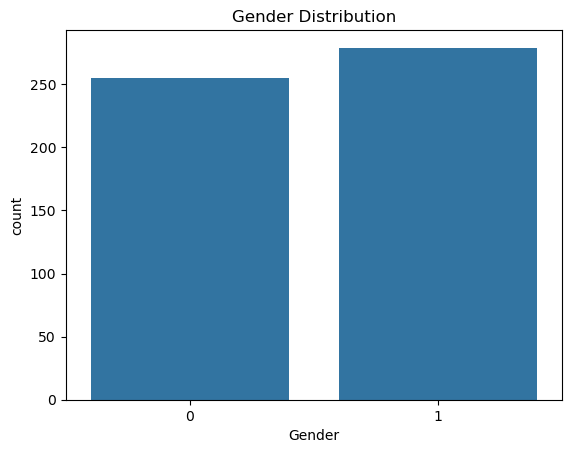

In [9]:
# Gender distribution
print("Gender Distribution:\n", data["Gender"].value_counts())
sns.countplot(x="Gender", data=data)
plt.title("Gender Distribution")
plt.show()

Anemia Result Distribution:
 Result
0    287
1    247
Name: count, dtype: int64


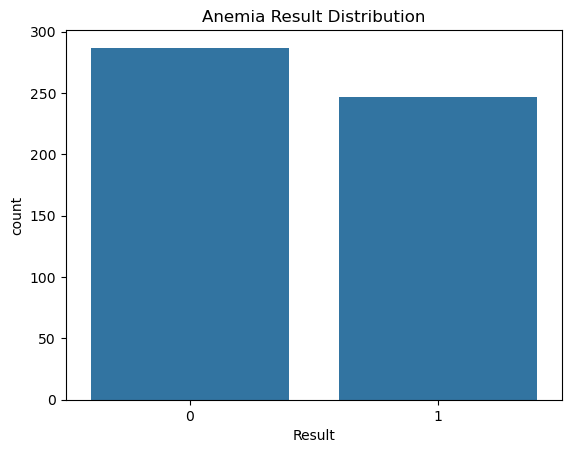

In [10]:
# Anemia result distribution
print("Anemia Result Distribution:\n", data["Result"].value_counts())
sns.countplot(x="Result", data=data)
plt.title("Anemia Result Distribution")
plt.show()

# Feature and Target Split

In [11]:
# Features (independent variables)
X = data.drop(columns=["Result"])

# Target variable (dependent variable)
y = data["Result"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (534, 5)
Target shape: (534,)


# Train-Test Split

In [12]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

print("Training set:", Xtrain.shape)
print("Testing set:", Xtest.shape)
print("Training set:", ytrain.shape)
print("Testing set:", ytest.shape)

Training set: (427, 5)
Testing set: (107, 5)
Training set: (427,)
Testing set: (107,)


# Data Preprocessing

In [13]:
# Identifying numerical and categorical features
num_features = X.select_dtypes(include=["number"]).columns
# 

# Numerical preprocessing: imputation + scaling
num_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])

# Combine preprocessing steps
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features)])
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV'], dtype='object'))])

# Model Pipeline (Random Forest)

In [14]:
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("forest", RandomForestClassifier(random_state=42))
])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV'], dtype='object'))])),
                ('forest', RandomForestClassifier(random_state=42))])

# Hyperparameter Tuning

In [15]:
# Define hyperparameter grid
param_grid = {
    "forest__n_estimators": [100, 200],
    "forest__max_depth": [None, 10, 20],
    "forest__min_samples_split": [2, 5]
}

# GridSearch with ROC-AUC as scoring metric
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

# Training the model

In [16]:
# Train the optimized model
grid_search.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Gender', 'Hemoglobin', 'MCH', 'MCHC', 'MCV'], dtype='object'))])),
                                       ('forest',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'forest__max_depth': [None, 10, 20],
                         'forest__min_samples_split': [2, 5],
                         'forest__n_estimators': [100, 200]},
             scoring='roc_auc')

In [17]:
# Best model after tuning
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'forest__max_depth': None, 'forest__min_samples_split': 2, 'forest__n_estimators': 200}


# Model Evaluation

In [18]:
# Predictions
y_pred = best_model.predict(Xtest)
y_prob = best_model.predict_proba(Xtest)[:, 1]

In [19]:
# Accuracy
accuracy = accuracy_score(ytest, y_pred)
print("Accuracy:", accuracy)

# Recall (Sensitivity)
recall = recall_score(ytest, y_pred)
print("Recall (Sensitivity):", recall)

# Classification Report
print("\nClassification Report:\n", classification_report(ytest, y_pred))


Accuracy: 1.0
Recall (Sensitivity): 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        49

    accuracy                           1.00       107
   macro avg       1.00      1.00      1.00       107
weighted avg       1.00      1.00      1.00       107



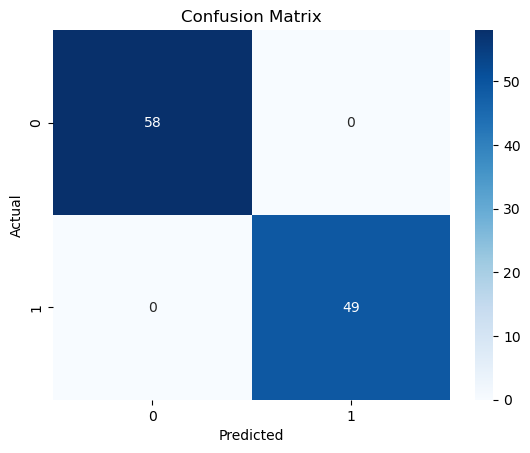

In [20]:
# Confusion Matrix
cm = confusion_matrix(ytest, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


ROC-AUC Score: 1.0


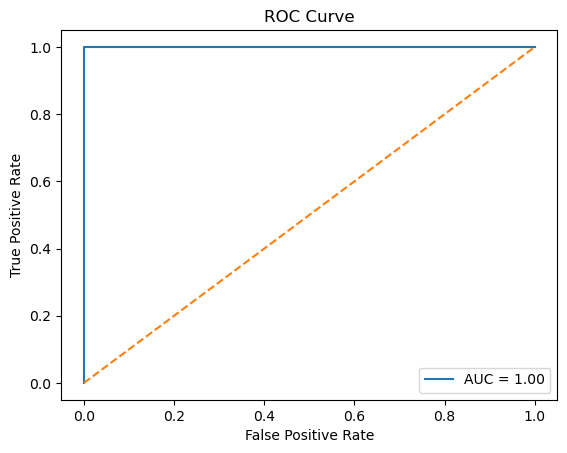

In [21]:
 # ROC-AUC Score
roc_auc = roc_auc_score(ytest, y_prob)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(ytest, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
